## Library setup

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import re
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
from tqdm import tqdm_notebook
from collections import Counter

: 

# Data and Pre-processing

In [2]:
# Path to the images
images_directory = 'dataset/Images/'
# Path to the captions
captions_path = 'dataset/captions.txt'

In [3]:
def load_captions(file_path):
    with open(file_path, 'r') as f:
        captions = f.readlines()
        # Lowercasing  the captions
        captions = [caption.lower() for caption in captions[1:]]
    return captions

def tokenize_captions(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    return tokenizer

# Loading the captions from the dataset
captions = load_captions(captions_path)
captions[:15:3]

['1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playhouse .\n',
 '1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with each other on the road .\n',
 '1001773457_577c3a7d70.jpg,two dogs on pavement moving toward each other .\n',
 '1002674143_1b742ab4b8.jpg,a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .\n']

## Cleaning the captions

In [4]:
def clean_text(text):
    # Removing punctuation marks
    text = re.sub(r'[^\w\s]', '', text)
    
    # Removing numbers
    text = re.sub(r'\d+', '', text)
    
    # Removing extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Cleaning the captions
cleaned_captions = [clean_text(caption.split(',')[1]) for caption in captions]
cleaned_captions[:15:2]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a little girl climbing into a wooden playhouse',
 'a little girl in a pink dress going into a wooden cabin',
 'a black dog and a tricolored dog playing with each other on the road',
 'two dogs of different breeds looking at each other on the road',
 'a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl',
 'a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it',
 'young girl with pigtails painting outside in the grass']

In [5]:
# Image ID + \t + Caption
captions_IDs = []
for i in range(len(cleaned_captions)):
    #  Adding 'start' word and 'end' word to the captions
    item = captions[i].split(',')[0]+'\t'+'start '+cleaned_captions[i]+' end\n'
    captions_IDs.append(item)
    
captions_IDs[:20:3], len(captions_IDs)

(['1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
  '1000268201_693b08cb0e.jpg\tstart a little girl climbing the stairs to her playhouse end\n',
  '1001773457_577c3a7d70.jpg\tstart a black dog and a tricolored dog playing with each other on the road end\n',
  '1001773457_577c3a7d70.jpg\tstart two dogs on pavement moving toward each other end\n',
  '1002674143_1b742ab4b8.jpg\tstart a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it end\n',
  '1003163366_44323f5815.jpg\tstart a man lays on a bench while his dog sits by him end\n',
  '1003163366_44323f5815.jpg\tstart a shirtless man lies on a park bench with his dog end\n'],
 40455)

### **Tokenizing** captions and setting **vocab size**

In [9]:
tokenizer = tokenize_captions(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1 # Thêm 1 cho từ dùng để padding
vocab_size

8586

### Splitting the data into tain, validation and test sets

In [35]:
# Storing all image IDs
all_image_ids = os.listdir(images_directory)

# Splitting image IDs
train_image_ids, val_image_ids = train_test_split(all_image_ids, test_size=0.2, random_state=42)
val_image_ids, test_image_ids = train_test_split(val_image_ids, test_size=0.2, random_state=42)

train_captions, val_captions, test_captions = [], [], []
for caption in captions_IDs:
    image_id, _ = caption.split('\t')
    
    if image_id in train_image_ids:
        train_captions.append(caption)
        
    elif image_id in val_image_ids:
        val_captions.append(caption)        

    elif image_id in test_image_ids:
        test_captions.append(caption)
        
    else:
        print('Unknown image ID !')

train_captions[0], val_captions[0], test_captions[0], len(train_captions)/5, len(val_captions)/5, len(test_captions)/5

('1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
 '1022454428_b6b660a67b.jpg\tstart a couple and an infant end\n',
 '103195344_5d2dc613a3.jpg\tstart a man in black is sitting next to a modern art structure in front of a glass building end\n',
 6472.0,
 1295.0,
 324.0)

## **Extracting Image features** using **The InceptionV3** model

In [11]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

def extract_image_features(model, image_path):
    img = preprocess_image(image_path)
    features = model.predict(img, verbose=0)
    return features

# Loading the pre-trained InceptionV3 model
inception_v3_model = InceptionV3(weights = 'imagenet', input_shape=(299, 299, 3))
inception_v3_model.layers.pop()
inception_v3_model = Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.layers[-2].output)

In [30]:
inception_v3_model.summary()
inception_v3_model.save("models/inception_v3_model.h5")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 149, 149, 32)         0         ['batch_normalization[0][0

## **Extracting Image features** using **VGG16** model

In [ ]:
# from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

# def preprocess_image(image_path):
#     img = load_img(image_path, target_size=(224, 224))  # VGG16 expects input images to be 224x224
#     img = img_to_array(img)
#     img = np.expand_dims(img, axis=0)
#     img = preprocess_input(img)  # Preprocess input according to VGG16 requirements
#     return img

# def extract_image_features(model, image_path):
#     img = preprocess_image(image_path)
#     features = model.predict(img, verbose=0)
#     return features

# # Loading the pre-trained VGG16 model
# vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# vgg16_model = Model(inputs=vgg16_model.inputs, outputs=vgg16_model.layers[-1].output)
# vgg16_model.save("models/vgg16_model")


In [12]:
train_image_features, val_image_features, test_image_features = {}, {}, {}  # A Dictionary to store image features with their corresponding IDs       

pbar = tqdm_notebook(total=len(all_image_ids), position=0, leave=True, colour='green') 

for caption in all_image_ids:
    image_id = caption.split('\t')[0]
    image_path = os.path.join(images_directory, image_id)
    image_features = extract_image_features(inception_v3_model, image_path) # Extracting features
    
    if image_id in train_image_ids:
        train_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)
    
    elif image_id in val_image_ids:
        val_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)
    
    elif image_id in test_image_ids:
        test_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)
    
    else:
        print('Unknown image ID !')
    
pbar.close()

  0%|          | 0/8091 [00:00<?, ?it/s]

# **Data Setup for Model Input**

In [13]:
def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size):
    num_samples = len(captions)
    image_ids = list(image_features.keys())
    while True:
        np.random.shuffle(image_ids)  # Shuffle image_ids for each epoch
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], []
            for caption in captions[start_idx:end_idx]:
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.rstrip('\n')
                seq = tokenizer.texts_to_sequences([caption_text])[0] # Tokenizing the caption
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i] # X_caption, Y
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X_images.append(image_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)
            
            yield [np.array(X_images), np.array(X_captions)], np.array(y)
         
        
# Defining the maximum length of captions
max_caption_length = max(len(caption.split()) for caption in cleaned_captions) + 1

# Defining the CNN output dimension (size of feature vector from InceptionV3)
cnn_output_dim = inception_v3_model.output_shape[1] # 2048


batch_size_train = 270
batch_size_val = 150

# Creating data generators for training and validation
train_data_generator = data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train)
val_data_generator = data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val)

In [14]:

# sample_batch = next(train_data_generator)
# print("Training sample batch shapes:")
# print("X_images:", sample_batch[0][0].shape)
# print("X_captions:", sample_batch[0][1].shape)
# print("y:", sample_batch[1].shape)
# print('=========================')
# sample_batch = next(val_data_generator)
# print("Validation sample batch shapes:")
# print("X_images:", sample_batch[0][0].shape)
# print("X_captions:", sample_batch[0][1].shape)
# print("y:", sample_batch[1].shape)

Training sample batch shapes:
X_images: (3258, 2048)
X_captions: (3258, 34)
y: (3258, 8586)
Validation sample batch shapes:
X_images: (1817, 2048)
X_captions: (1817, 34)
y: (1817, 8586)


# **Defining** the **Image Captioning** Model


In [15]:
def build_model(vocab_size, max_caption_length, cnn_output_dim):
    # Encoder Model
    input_image = Input(shape=(cnn_output_dim,), name='Features_Input')
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(256, activation='relu')(fe1) # Adding a Dense layer to the CNN output to match the decoder output size
    fe3 = BatchNormalization()(fe2)
    
    # Decoder Model
    input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
    se2 = LSTM(256)(se1)
    
    # Output
    decoder1 = add([fe3, se2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder2)

    # Returning The Model
    model = Model(inputs=[input_image, input_caption], outputs=outputs, name='Image_Captioning')
    return model
    
# Building the model
caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)

optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

caption_model.summary()

Model: "Image_Captioning"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 Features_Input (InputLayer  [(None, 2048)]               0         []                            
 )                                                                                                
                                                                                                  
 batch_normalization_94 (Ba  (None, 2048)                 8192      ['Features_Input[0][0]']      
 tchNormalization)                                                                                
                                                                                                  
 Sequence_Input (InputLayer  [(None, 34)]                 0         []                            
 )                                                                                 

In [16]:
plot_model(caption_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Training the model
##### **Training** will **stop** if there is **no improvement** in the **validation loss** for **3 consecutive epochs**.

In [17]:
# Defining early stopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    return lr * tf.math.exp(-0.6)

# Learning Rate Scheduler
lr_schedule = LearningRateScheduler(lr_scheduler)

history = caption_model.fit(train_data_generator, steps_per_epoch=len(train_captions) // batch_size_train,
                        validation_data=val_data_generator, validation_steps=len(val_captions) // batch_size_val,
                        epochs=5, callbacks=[early_stopping, lr_schedule])

Epoch 1/15

127/127 [==============================] - 234s 2s/step - loss: 4.5484 - val_loss: 3.7690 - lr: 0.0055
Epoch 2/15
127/127 [==============================] - 253s 2s/step - loss: 3.2966 - val_loss: 3.3518 - lr: 0.0030
Epoch 3/15
127/127 [==============================] - 371s 3s/step - loss: 2.9047 - val_loss: 3.2441 - lr: 0.0017
Epoch 4/15
127/127 [==============================] - 550s 4s/step - loss: 2.6833 - val_loss: 3.2085 - lr: 9.0718e-04
Epoch 5/15
127/127 [==============================] - 521s 4s/step - loss: 2.5457 - val_loss: 3.1993 - lr: 4.9787e-04
Epoch 6/15
127/127 [==============================] - 397s 3s/step - loss: 2.4625 - val_loss: 3.1959 - lr: 2.7324e-04
Epoch 7/15
127/127 [==============================] - 293s 2s/step - loss: 2.4122 - val_loss: 3.2017 - lr: 1.4996e-04
Epoch 8/15
127/127 [==============================] - 522s 4s/step - loss: 2.3834 - val_loss: 3.2074 - lr: 8.2297e-05
Epoch 9/15
127/127 [==============================] - 494s 4s/step 

In [18]:

caption_model.save('models/model.keras')
caption_model.save_weights('models/mine_model_weights.keras')

### Visualizing the model performance

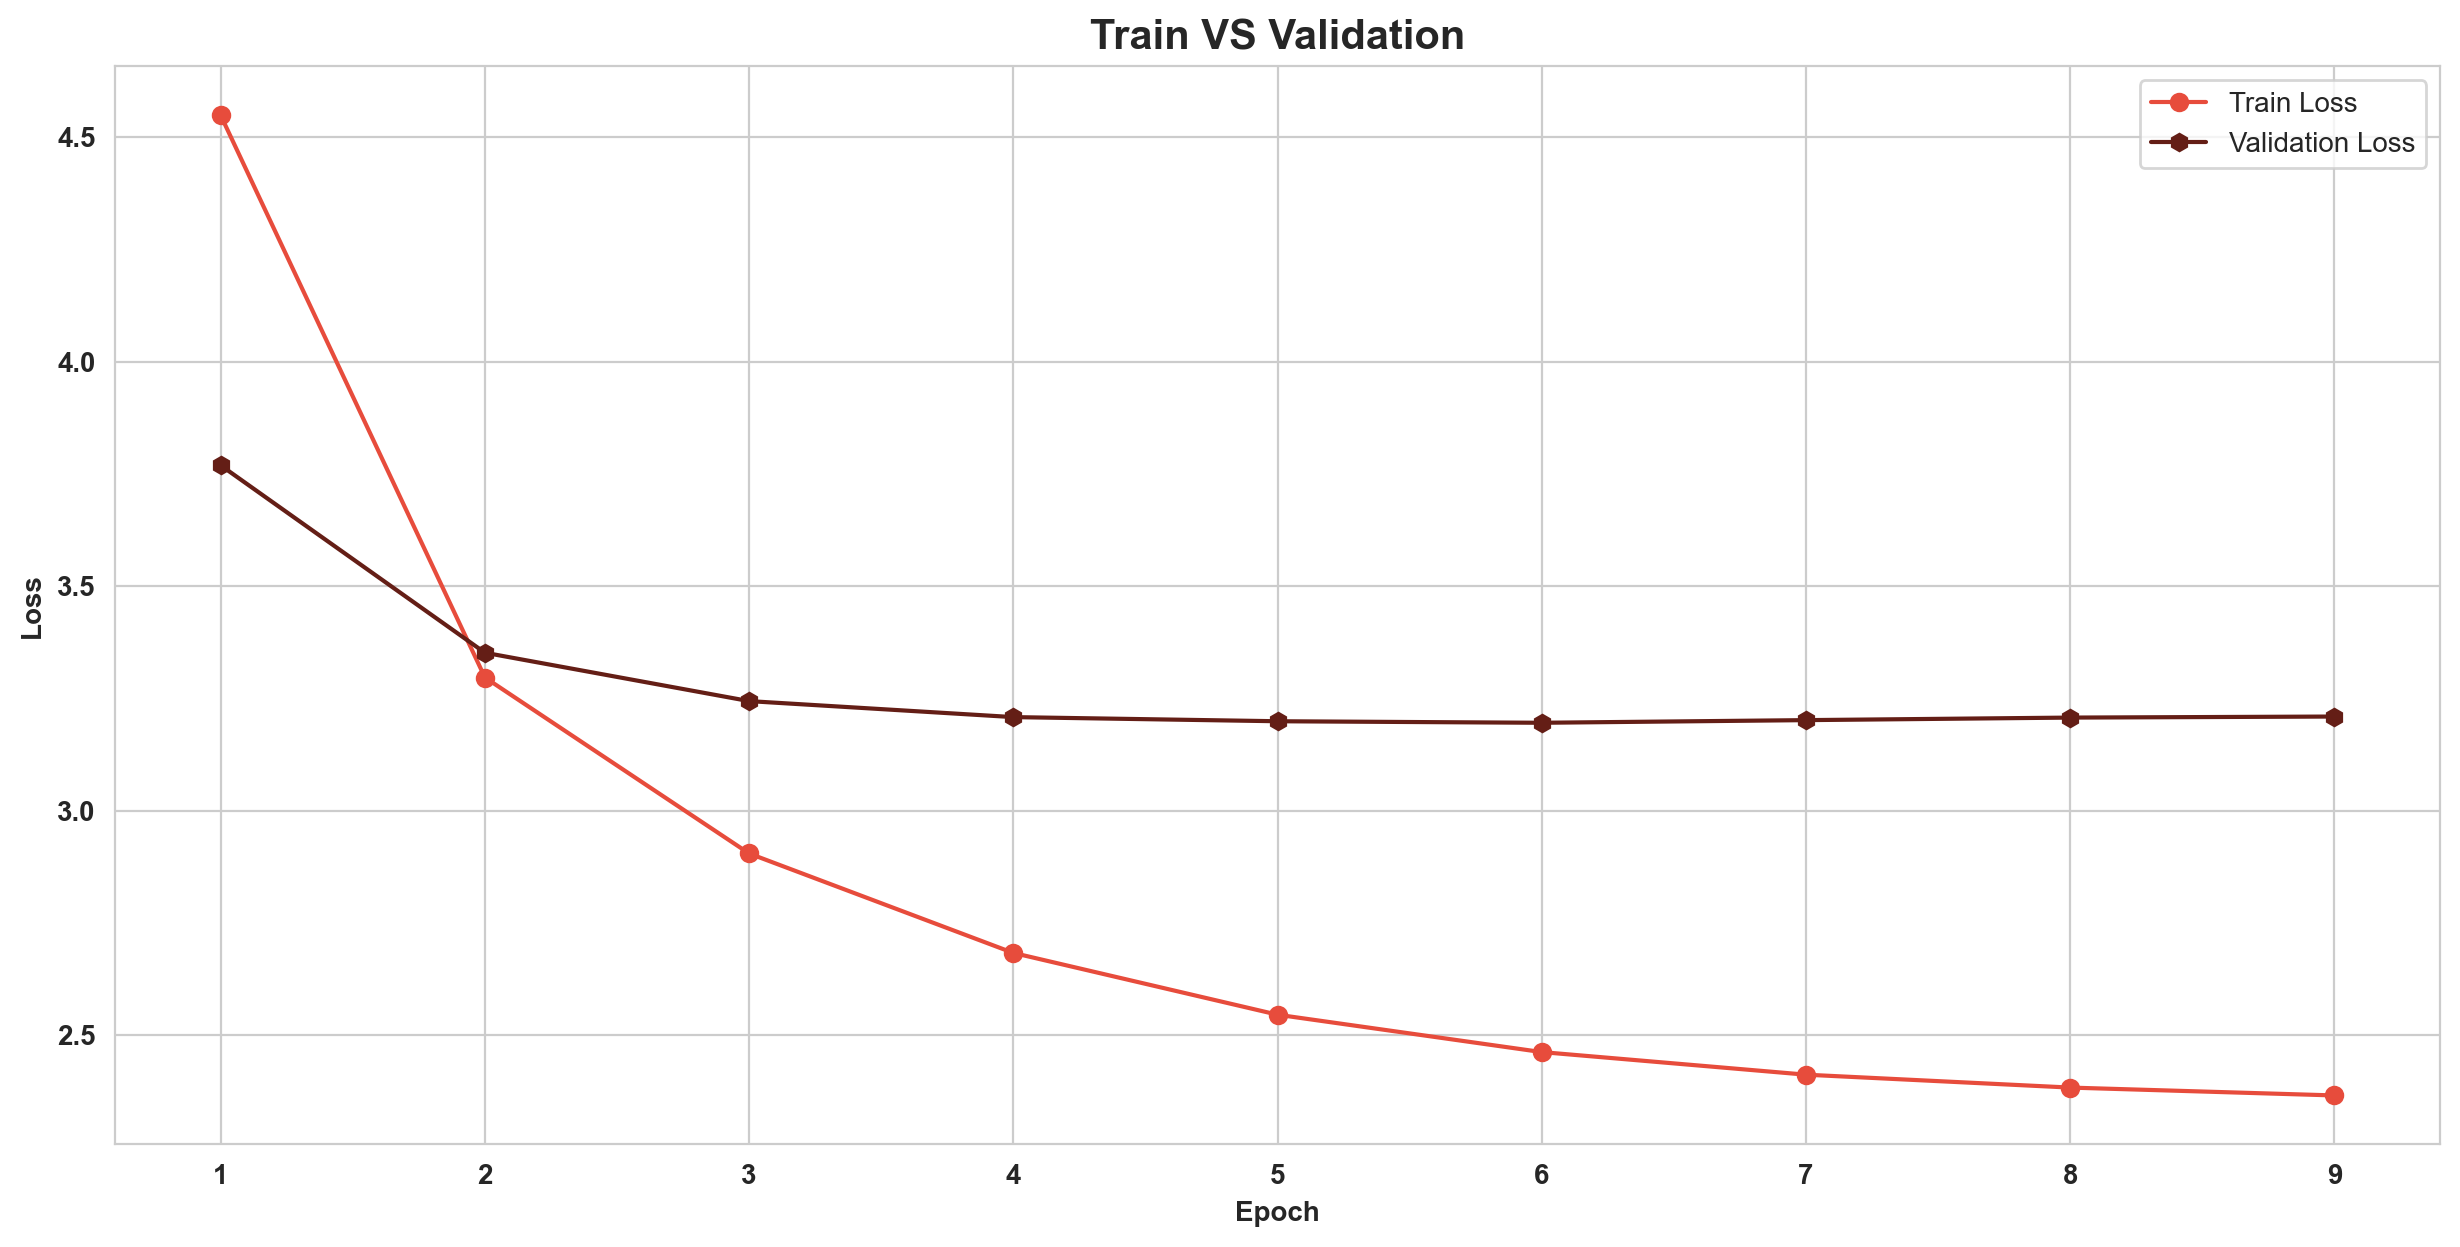

In [19]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

In [20]:
def greedy_generator(image_features): # A function to generate captions
    # Each caption is started with the word 'start'
    in_text = 'start '
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length).reshape((1,max_caption_length))
        prediction = caption_model.predict([image_features.reshape(1,cnn_output_dim), sequence], verbose=0)
        idx = np.argmax(prediction)
        word = tokenizer.index_word[idx]
        # Adding the predicted word to the sequence
        in_text += ' ' + word
        # When the model returns the word 'end' (which is the end word), the generating loop must be stopped 
        if word == 'end':
            break
            
    in_text = in_text.replace('start ', '')
    in_text = in_text.replace(' end', '')
    
    return in_text

In [21]:
# Calculates BLEU score of predictions
def BLEU_score(actual, greedy):
    # Calculating the BLEU score by comparing the predicted caption with five actual captions.
    score_greedy_1 = corpus_bleu(actual, greedy, weights=(0.3, 0.3, 0.3, 0))
    score_greedy_2 = corpus_bleu(actual, greedy, weights=(0.25, 0.25, 0.25, 0.25))
    
    return [
        (f'BLEU-2: {round(score_greedy_2, 5)}'),
        (f'BLEU-1: {round(score_greedy_1, 5)}'),
        (f'Predict: {greedy[0]}'),
        (f'Actual: {actual[0]}'),
    ]

In [22]:
# A dictionary to access actual captions of each image by its ID
test_actual_captions = {}
for item in test_captions:
    image_id, caption = item.split('\t')
    if image_id not in test_actual_captions:
        test_actual_captions[image_id] = []
    test_actual_captions[image_id].append(caption)

In [23]:
# Generating captions
generated_captions = {}

pbar = tqdm_notebook(total=len(test_image_features), position=0, leave=True, colour='green')
for image_id in test_image_features:
    cap = greedy_generator(test_image_features[image_id])
    generated_captions[image_id] = cap
    pbar.update(1)
    
pbar.close()

  0%|          | 0/122 [00:00<?, ?it/s]

## Visualizing some of the **test images** along with their corresponding **generated captions**

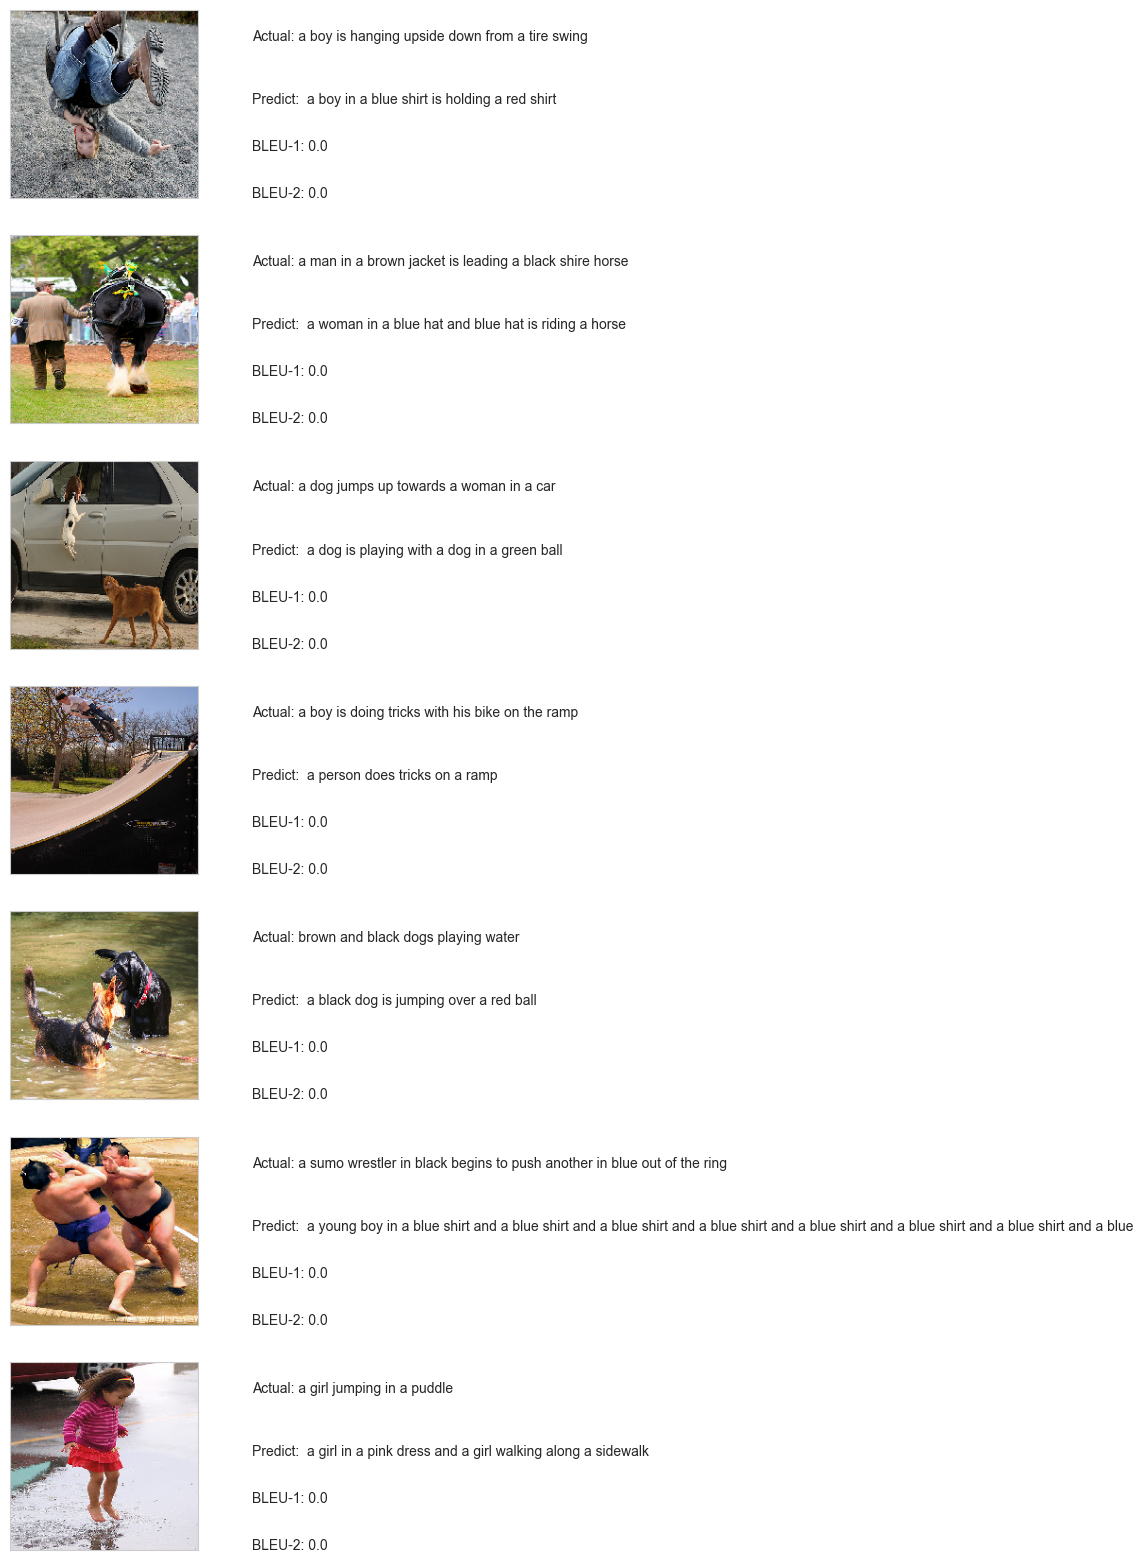

In [24]:
def visualization(data, greedy_caps,evaluator, num_of_images):
    keys = list(data.keys()) # List of all test images
    images = [np.random.choice(keys) for i in range(num_of_images)] # Randomly selected images
    
    count = 1
    fig = plt.figure(figsize=(6,20))    
    for filename in images:
        actual_cap = data[filename]
        actual_cap = [x.replace("start ", "") for x in actual_cap] # Removing the start token
        actual_cap = [x.replace(" end", "") for x in actual_cap] # Removing the end token
        
        # Generating captions
        greedy_cap = greedy_caps[filename]
        
        # Getting the bleu score
        caps_with_score = evaluator(actual_cap, [greedy_cap]*(len(actual_cap)))
    
        image_load = load_img(images_directory+filename, target_size=(199,199,3))
        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(caps_with_score))
        for i, text in enumerate(caps_with_score):
            ax.text(0,i,text,fontsize=10)
        count += 1
    plt.show()

visualization(test_actual_captions, generated_captions, BLEU_score, 7)

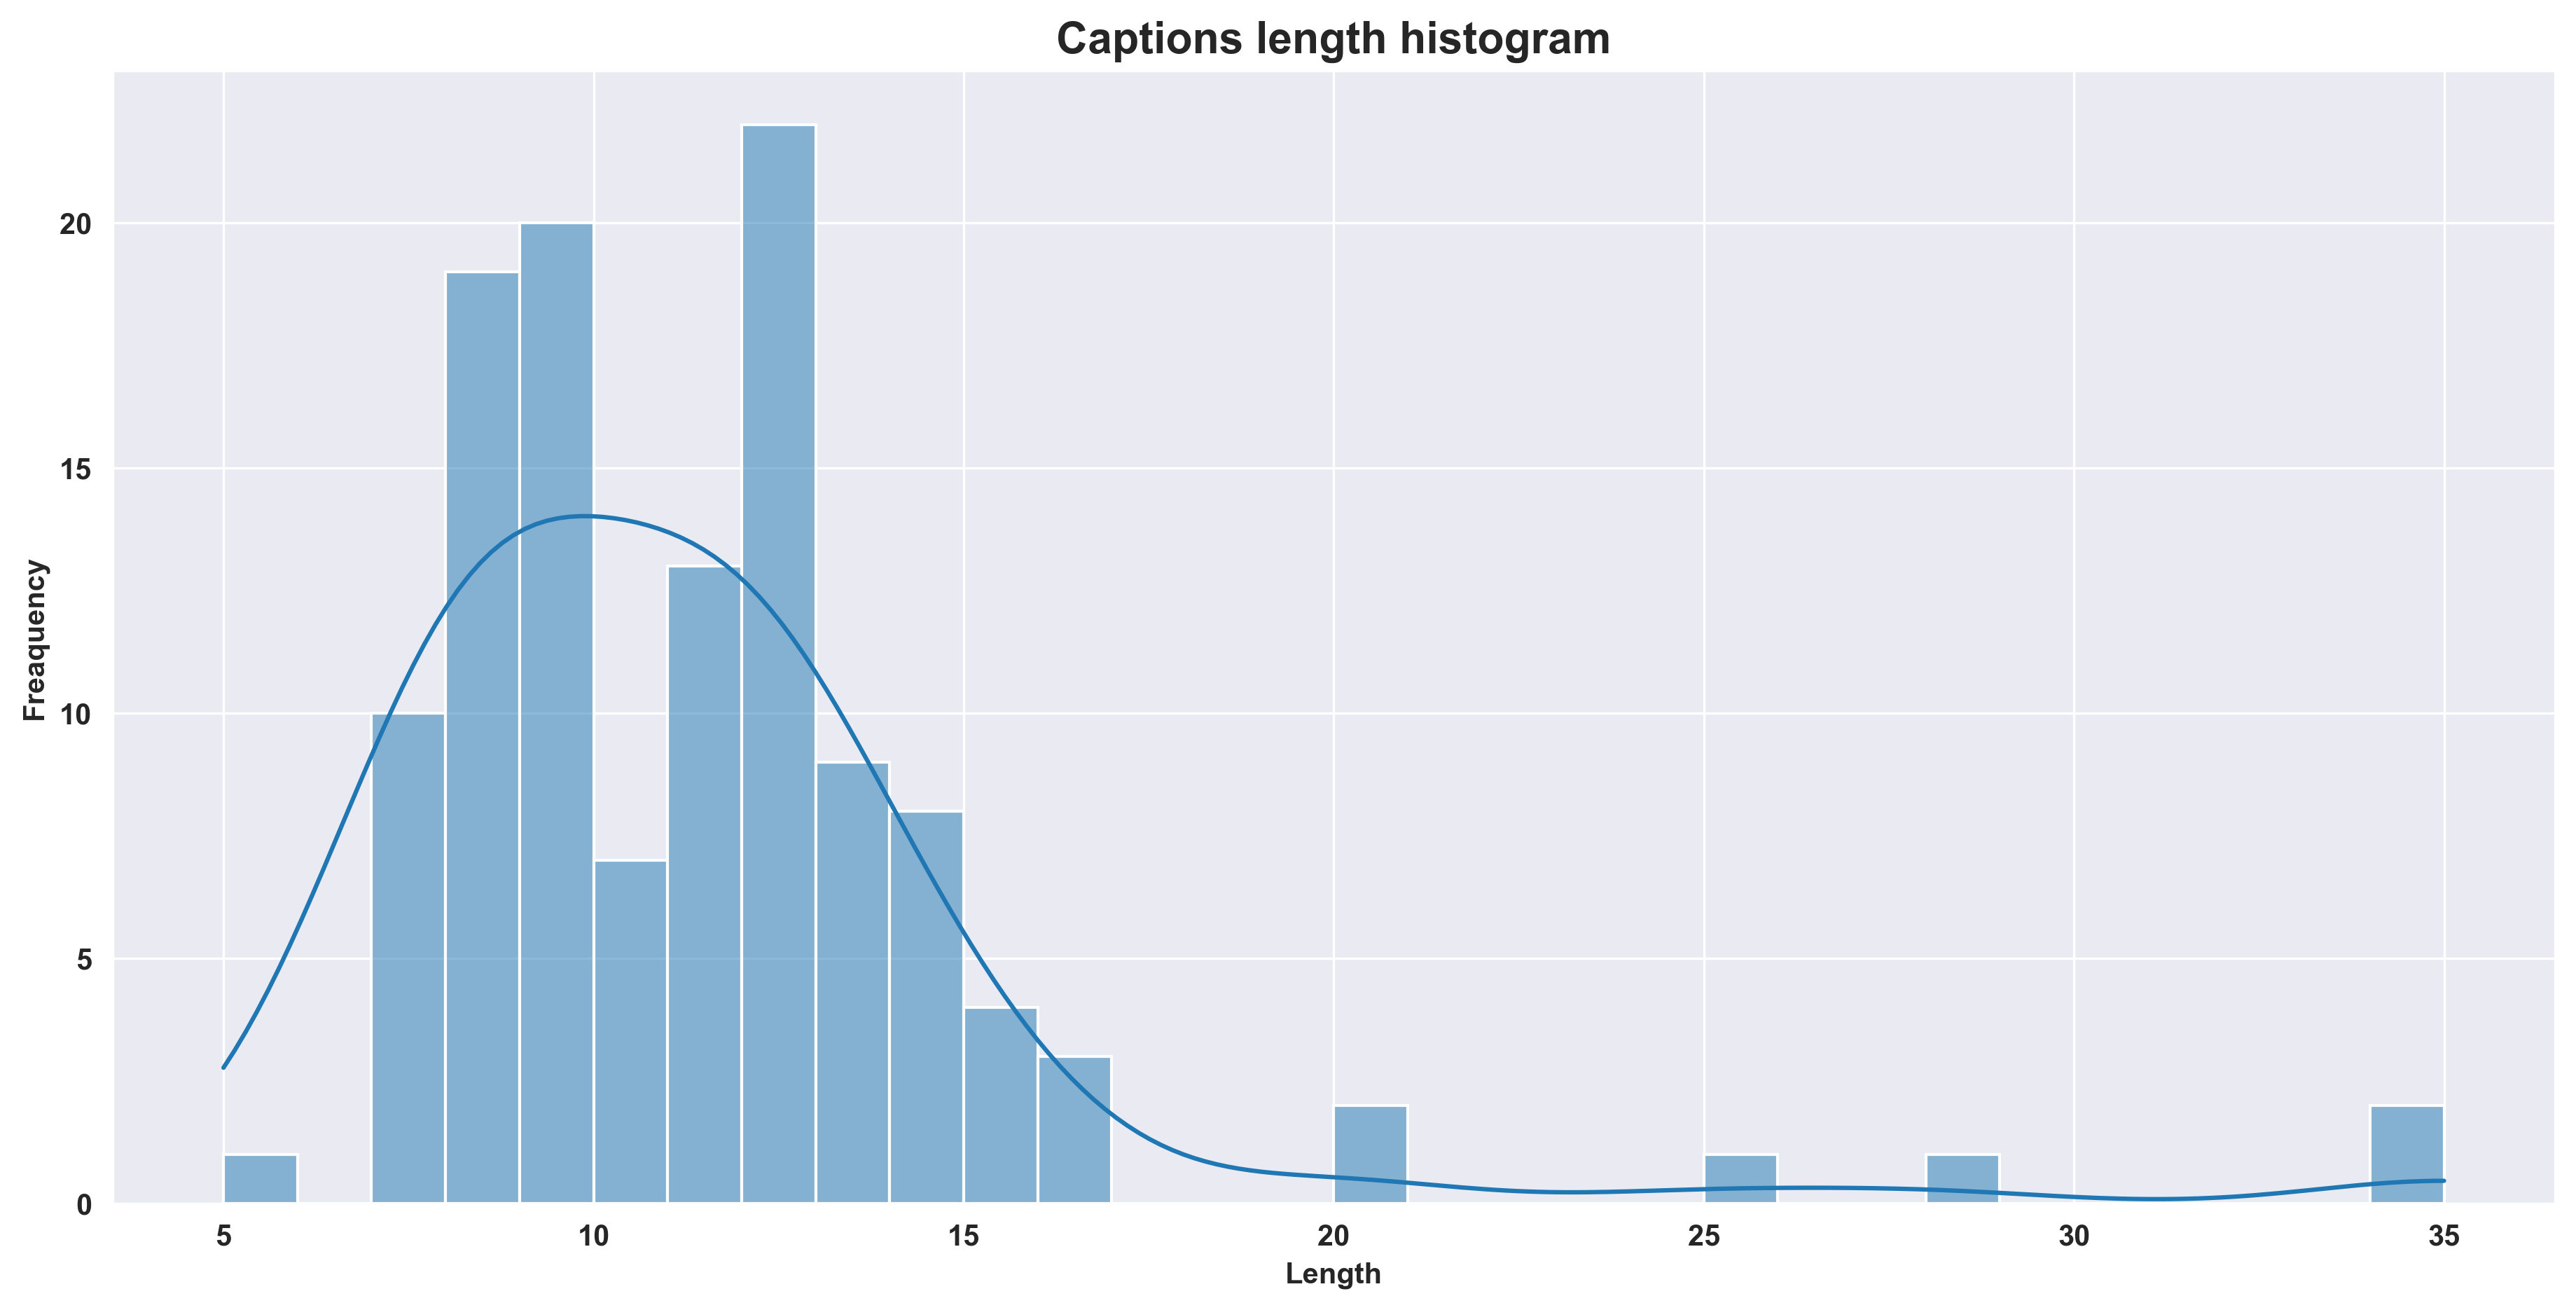

In [25]:
captions_length(list(generated_captions.values()))

In [26]:
word_occurrences(list(generated_captions.values()))